# Simple GAN Model





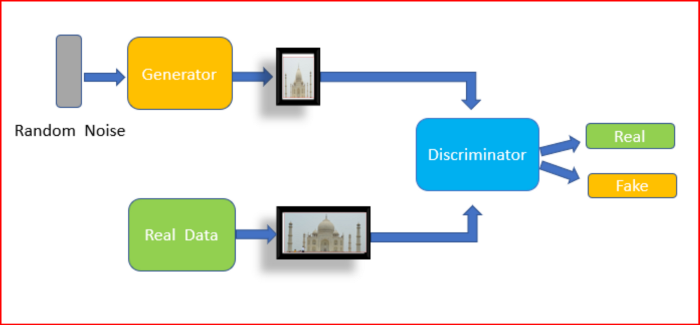

Generator’s objective will be to generate data that is very similar to the training data. Data generated from Generator should be indistinguishable from the real data.
Discriminator takes two sets of input, one input comes from the training dataset(real data) and the other input is the dataset generated by Generator.

Importing Necessary Libraries

In [ ]:
from keras.datasets import mnist # Using MNIST Dataset
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import adam_v2
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

Understanding MNIST Data

In [ ]:
x,y=mnist.load_data()

In [ ]:
(trainX, trainy), (testX, testy) = mnist.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape)) #60000 Images in the training set. Each having dimension 28 x 28
print('Test: X=%s, y=%s' % (testX.shape, testy.shape)) #10000 Images in the test set. Each having dimension 28 x 28

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


Defining the  input image dimensions


In [ ]:
img_rows = 28
img_cols = 28
channels = 1  # 1 for grey scale image . 3 for RGB images
img_shape = (img_rows, img_cols, channels)

Building Generator

In [ ]:
def build_generator():
    
    #noise_shape = (784,)
    noise_shape = (100,)                                   # Input to the generator is a noise. Here 1D array of size 100 (latent vector / noise)

#Define your generator network 
#Here we are only using Dense layers. But network can be complicated based
#on the application. For example, you can use VGG for super res. GAN.         

    model = Sequential()

    model.add(Dense(256, input_shape=noise_shape))  # Noise is given as input to the sequential model
    model.add(LeakyReLU(alpha=0.2))                 #Alpha — α is a hyperparameter which controls the underlying value to which the function saturates negatives network inputs.
    model.add(BatchNormalization(momentum=0.8))     #Momentum — Speed up the training
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=noise_shape)
    img = model(noise)  
    
                                  #Generated image

    return Model(noise, img)                          # A 1D array is given as input with 100 values, The generator generates a 2D fake image of 28 x 28 x 1




Building Discriminator

In [ ]:
def build_discriminator():                        # Discriminator is similar to a binary classifier which classifies whether an image is real/fake
                                                  #Given an input image, the Discriminator outputs the likelihood of the image being real.

    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)                                  # An image is given as input, Discriminator returns the image and its validity as output
                                                                #The validity is the Discriminator’s guess of input being real or not.

In [ ]:
def train(epochs, batch_size, save_interval):

    
    (x_train, _), (_, _) = mnist.load_data() # Load the dataset - We need the real images only

   #####
    X_train = x_train[:2000] # slicing to take 2000 image

                               
    X_train = (X_train.astype(np.float32) - 255) / 255                     # Convert to float and Rescale -1 to 1 (Can also do 0 to 1)

    
    X_train = np.expand_dims(X_train, axis=3)                               #Adding and extra channels dimension. 
                                                                            #As the input to our gen and discr. has a shape 28x28x1.

    half_batch = int(batch_size / 2)                                        # Half of the real data is given to discriminator,(64 will be half batch here)
                                                                            # Half of the other data wil be images generated by Generator


                                                                  #We then loop through a number of epochs to train our Discriminator by first selecting
                                                                  #a random batch of images from our true dataset, generating a set of images from our
                                                                  #Generator, feeding both set of images into our Discriminator, and finally setting the
                                                                  #loss parameters for both the real and fake images, as well as the combined loss. 

    for epoch in range(epochs):                                   # Training the Discriminator First

  
        idx = np.random.randint(0, X_train.shape[0], half_batch)   # Select a random half batch of real images
        imgs = X_train[idx]

        noise = np.random.normal(0, 1, (half_batch, 100))         # Creating Noise-Gaussian/Normally distribuited noise. This will create 100 noise values

        
        #noise_factor=.2
       #noise = imgs + noise_factor * np.random.normal(size=(imgs.shape))
        #print(noise.shape)
        #noise.shape = (half_batch,784)
        #print(noise.shape)
 
        
        
        gen_imgs = generator.predict(noise)                       # This noise is given as input to generator, It then Generate a half batch of fake images

                                                                  # Train the discriminator on real and fake images, separately  
       
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))   # input is real images
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1))) # input is fake images
   
                                                                 #take average loss from real and fake images, to get  a single loss value
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 

                                                                  #And within the same loop we train our Generator, by setting the input noise and
                                                                  #ultimately training the Generator to have the Discriminator label its samples as valid
                                                                  #by specifying the gradient loss.

        # ---------------------
        #  Train Generator
        # ---------------------
                                                                  #Create noise vectors as input for generator. 
                                                                  #Create as many noise vectors as defined by the batch size. 
                                                                  #Based on normal distribution. Output will be of size (batch size, 100)
       # idx = np.random.randint(0, X_train.shape[0], batch_size)   # Select a random half batch of real images
        #imgg = X_train[idx]
        #noise = imgg + noise_factor * np.random.normal(size=(imgg.shape))  
       # noise.shape = (batch_size,784)

        noise = np.random.normal(0, 1, (batch_size, 100)) 
        
 

                                                                  # The generator wants the discriminator to label the generated samples as valid (ones)
                                                                  #This is where the genrator is trying to trick discriminator into believing
                                                                  #the generated image is true (hence value of 1 for y)

        valid_y = np.array([1] * batch_size)                       #Creates an array of all ones of size=batch size (coulmn vector)

                                                                 # Generator is part of combined where it got directly linked with the discriminator
                                                                 # Train the generator with noise as x and 1 as y. 
                                                          


        g_loss = combined.train_on_batch(noise, valid_y)         # Combined model is having both generator and discriminator.   
                                                                 # Generating fake images by providing the noise
                                                                 # Fooling discriminator by telling that the generated fake images are real

                                                                 # Discriminator should distinguish between real and fake
                                                                 # If generator did a great job then the discriminator will not be able to distinguish it

                                                                  #Additionally, in order for us to keep track of our training process, we print the
                                                                  #progress and save the sample image output depending on the epoch interval specified.  
                                                                  # Plot the progress
        
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

                                                                  # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            save_imgs(epoch)

                                                                  #when the specific sample_interval is hit, save the generated images

      

In [ ]:

from google.colab import drive
drive.mount('/content/gdrive')
                                          # To store the generated images to a folder in drive . we need to mount it

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
def save_imgs(epoch):
    r, c = 5, 5                                               # We get a 5 x 5 grid of images
    #noise = np.random.normal(0, 1, (r * c, 784))
    noise = np.random.normal(0, 1, (r * c, 100))              
    gen_imgs = generator.predict(noise)                       

                                                              # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("/content/gdrive/MyDrive/GAN/mnist_%d.png" % epoch)
    plt.close()
                                                        #This function saves our images for us to view after the given interval of epochs


#############################################################################################################################################


In [ ]:

                                                        #Let us also define our optimizer for easy use later on.
                                                        #if you need to change it, you can change it easily here
optimizer = adam_v2.Adam(0.0002, 0.5)                           #Learning rate and momentum.

                                                        # Build and compile the discriminator first. 
                                                        #Generator will be trained as part of the combined model, later. 

                                                                         
                                                        #Binary cross entropy is a better as we are doing prediction from discriminator
                                                        
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

                                                        #build and compile our Discriminator, pick the loss function

                                                        #SInce we are only generating (faking) images, let us not track any metrics.
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

                                                        ##This builds the Generator and defines the input noise. 

                                                        #In a GAN the Generator network takes noise z as an input to produce its images.  
#z = Input(shape=(784,))
z = Input(shape=(100,))                                 #Our random input to the generator
img = generator(z)

                                                          #This ensures that when we combine our networks we only train the Generator.
                                                          #While generator training we do not want discriminator weights to be adjusted. 
                                                          #This Doesn't affect the above descriminator training.     
discriminator.trainable = False  

                                                      #This specifies that our Discriminator will take the images generated by our Generator

                                                      #set its output to a parameter called valid, which will indicate whether the input is real or not. 
                                                      #Validity check on the generated image

                                                  
valid = discriminator(img)                            

                                                      #Here we combined the models
                                                      #create a combined model that is a concatenation of generator following by discreminator 
                                                      #also set our loss function and optimizer. 

                                                      #Again, we are only training the generator here. 
                                                      #The ultimate goal here is for the Generator to fool the Discriminator. 

       # The combined model(stacked generator & discriminator) takes noise as input => generates images => determines validity

                                                      
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)




Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_7 (Dense)             (None, 512)               401920    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 533,505
Trainable params: 533,505
Non-tr

In [ ]:
train(epochs=10, batch_size=32, save_interval=10)


 #Save model for future use to generate fake images
                                                    
generator.save('/content/gdrive/MyDrive/model_gan/generator_model.h5')               
                
                                                    #Epochs dictate the number of backward and forward propagations, the batch_size
                                                    #indicates the number of training samples per backward/forward propagation, and the
                                                    #sample_interval specifies after how many epochs we call our sample_image function

0 [D loss: 0.697257, acc.: 46.88%] [G loss: 0.782975]
1 [D loss: 0.342342, acc.: 87.50%] [G loss: 0.824747]
2 [D loss: 0.324136, acc.: 87.50%] [G loss: 0.880805]
3 [D loss: 0.290088, acc.: 96.88%] [G loss: 0.951578]
4 [D loss: 0.277291, acc.: 93.75%] [G loss: 1.076464]
5 [D loss: 0.295054, acc.: 90.62%] [G loss: 1.160744]
6 [D loss: 0.252497, acc.: 93.75%] [G loss: 1.367999]
7 [D loss: 0.198274, acc.: 96.88%] [G loss: 1.607340]
8 [D loss: 0.133098, acc.: 100.00%] [G loss: 1.735762]
9 [D loss: 0.128925, acc.: 100.00%] [G loss: 1.766446]


After 0 th epoch

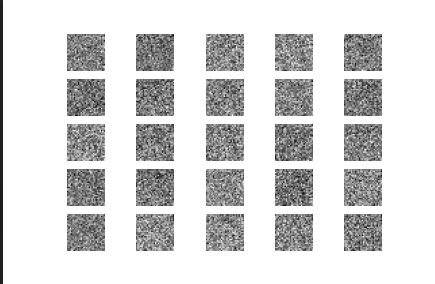

After 10000 epoch

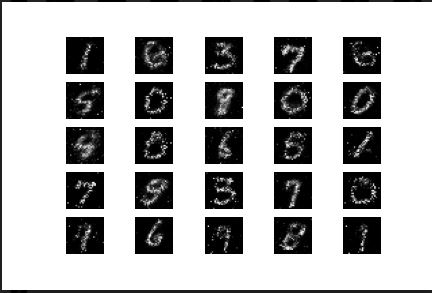

In [ ]:
# Display a single image using the epoch number
import PIL
def display_image(epoch_no):
  return PIL.Image.open('/content/gdrive/MyDrive/GAN/mnist_{:04d}.png'.format(epoch_no))

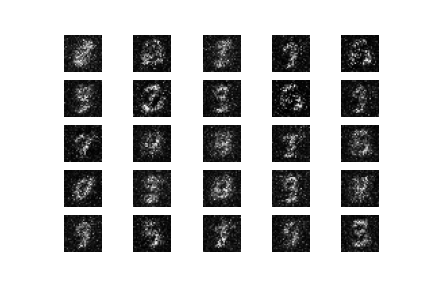

In [ ]:
display_image(1000)

In [ ]:
# To display image as a GIF

import glob
from PIL import Image

# filepaths
fp_in = "/content/gdrive/MyDrive/GAN/mnist_*.png" # Image folder location
fp_out = "/content/gdrive/MyDrive/GAN/image.gif"         # Location to save the gif


img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=200, loop=0)

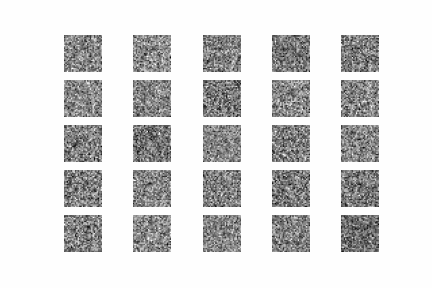

In [ ]:

from IPython.display import Image
Image(open('/content/gdrive/MyDrive/GAN/image.gif','rb').read())



In [ ]:
from keras.models import load_model
from numpy import asarray
from matplotlib import pyplot
from numpy.random import randn

# load model
model = load_model('/content/generator_model.h5')

#To create same image, suppy same vector each time
# all 0s
#vector = asarray([[0. for _ in range(100)]])  #Vector of all zeros

#To create random images each time...
vector = randn(100) #Vector of random numbers (creates a column, need to reshape)
vector = vector.reshape(1, 100)

# generate image
X = model.predict(vector)

# plot the result
pyplot.imshow(X[0, :, :, 0], cmap='gray_r')
pyplot.show()

#Uncomment to run this part of the code....
##############################################
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot as plt
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	plt.show()
# load model
model = load_model('/content/generator_model.h5')
# generate images
#Generate 16 images, each image provide a vector of size 100 as input
latent_points = generate_latent_points(100, 16) 
# generate images
X = model.predict(latent_points)
# plot the result
save_plot(X, 4)  #Plot 4x4 grid (Change to 5 if generating 25 images)

OSError: ignored